In [1]:
from torch.utils.data import Dataset,DataLoader
import torch
from torch import tensor
import torch.nn as nn
import torch.nn.functional as F
import glob
import os
from functools import partial
from PIL import Image
import matplotlib.pyplot as plt
from torchvision import transforms
from torch import optim
from tqdm import tqdm
import numpy as np
from mmseg.models.uda.refinement import Encoder
from torch.optim.lr_scheduler import OneCycleLR
import random
from Datasets import WeihToI3
from mmseg.models.uda.refinement import EncodeDecode
#from mmseg.models.segmentors.base import UNet
from mmseg.models.uda.dacs import logging,batch_extract_components
from get_results import calculate_iou_and_dice
import pandas as pd
from models import TransUNetLike
from scipy.ndimage import label as scipy_label
from torch.utils.tensorboard import SummaryWriter
import cv2

/home/sow/venv/prism-uda/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def drop_ones(mask, drop_ratio=0.3):
    rand_vals = torch.rand_like(mask.float())
    drop_mask = (rand_vals > drop_ratio) | (mask == 0)
    return mask * drop_mask

In [2]:

df = pd.read_csv('./unet_train_iou_log_final.csv')
df.mean()

iteration        841.496919
ema_vs_gt_iou      0.792255
sam_vs_gt_iou      0.105006
pl_vs_gt_iou       0.295416
ema_vs_pl_iou      0.338215
sam_vs_pl_iou      0.073812
dtype: float64

In [3]:
df = pd.read_csv('./unet_test_iou_log_final.csv')
df.mean()

iteration        1792.000000
ema_vs_gt_iou       0.469145
sam_vs_gt_iou       0.609988
pl_vs_gt_iou        0.470007
ema_vs_pl_iou       0.961024
sam_vs_pl_iou       0.442005
dtype: float64

In [2]:
ds = WeihToI3(mode="train")

In [3]:
a = ds[1][0].float().unsqueeze(0)

In [4]:
a.shape

torch.Size([1, 1, 256, 256])

In [5]:
model = EncodeDecode("cpu")

In [8]:
model(a,a).shape

torch.Size([1, 2, 256, 256])

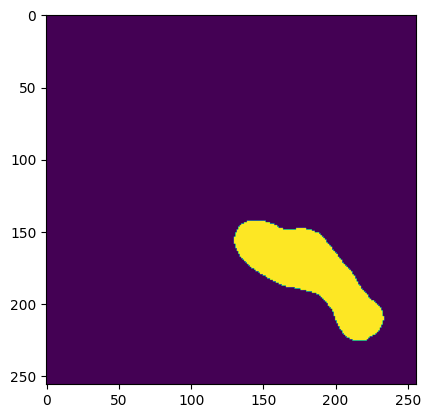

In [13]:
plt.imshow(a.squeeze())

In [6]:
ds[1][1].shape

torch.Size([1, 256, 256])

In [7]:
image, pl_image, sam_image, gt_image = ds[1]

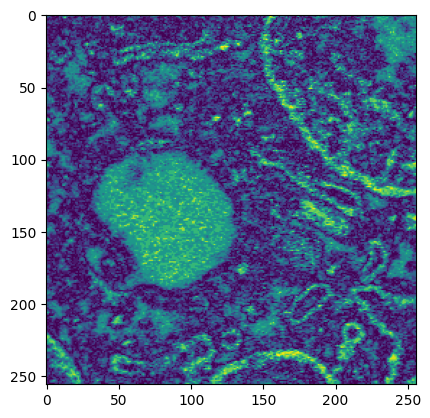

In [10]:
plt.imshow(image.squeeze())

In [2]:
def extract_mix_redistribute_components(mask1: torch.Tensor, mask2: torch.Tensor, 
                                      shuffle: bool = True, 
                                      min_component_size: int = 10):
    """
    Extract connected components from two masks, mix them, and redistribute into two new masks.
    Optimized version using OpenCV for maximum performance.
    
    Args:
        mask1 (torch.Tensor): First binary mask (any shape, will be squeezed to 2D)
        mask2 (torch.Tensor): Second binary mask (any shape, will be squeezed to 2D)
        shuffle (bool): Whether to randomly shuffle components before redistribution
        min_component_size (int): Minimum size for a component to be kept
    
    Returns:
        Tuple[torch.Tensor, torch.Tensor, Dict]: Two redistributed masks (same shape as input) and metadata
    """
    # Handle tensor shapes - convert to numpy for processing
    original_device = mask1.device
    original_dtype = mask1.dtype
    original_shape1 = mask1.shape
    original_shape2 = mask2.shape
    
    if len(mask1.shape) > 2:
        mask1 = mask1.squeeze()
        mask2 = mask2.squeeze()
    
    # Convert to numpy for OpenCV processing
    mask1_np = mask1.cpu().numpy().astype(np.uint8)
    mask2_np = mask2.cpu().numpy().astype(np.uint8)
    H, W = mask1_np.shape
    
    # Calculate different regions for efficient component extraction
    mask1_only = mask1_np & (~mask2_np)
    mask2_only = mask2_np & (~mask1_np)
    intersection = mask1_np & mask2_np
    
    # Extract all components efficiently
    all_components = []
    component_metadata = []
    
    # Process each region separately for better performance
    regions = [
        (mask1_only, 'mask1_only'),
        (mask2_only, 'mask2_only'), 
        (intersection, 'intersection')
    ]
    
    for region_mask, source_name in regions:
        if region_mask.sum() > 0:  # Only process if region has pixels
            # OpenCV connected components - fastest method
            num_labels, labels = cv2.connectedComponents(region_mask, connectivity=4)
            
            # Extract each component (skip label 0 which is background)
            for label_id in range(1, num_labels):
                component_mask = (labels == label_id).astype(np.uint8)
                component_size = np.sum(component_mask)
                
                # Filter out small components
                if component_size >= min_component_size:
                    all_components.append(component_mask)
                    component_metadata.append({
                        'source': source_name,
                        'size': component_size,
                        'original_label': label_id
                    })
    
    # Handle edge case: no components found
    if len(all_components) == 0:
        empty_mask = torch.zeros_like(mask1)
        return empty_mask, empty_mask, {'total_components': 0, 'redistribution': []}
    
    # Shuffle components if requested
    if shuffle:
        combined_data = list(zip(all_components, component_metadata))
        random.shuffle(combined_data)
        all_components, component_metadata = zip(*combined_data)
        all_components = list(all_components)
        component_metadata = list(component_metadata)
    
    # Redistribute components into two masks
    # Strategy: alternate assignment or use more sophisticated distribution
    new_mask1 = np.zeros((H, W), dtype=np.uint8)
    new_mask2 = np.zeros((H, W), dtype=np.uint8)
    
    redistribution_info = []
    
    # Alternate assignment for balanced distribution
    for i, (component, metadata) in enumerate(zip(all_components, component_metadata)):
        if i % 2 == 0:
            new_mask1 |= component
            assigned_to = 'mask1'
        else:
            new_mask2 |= component
            assigned_to = 'mask2'
        
        redistribution_info.append({
            'component_id': i,
            'assigned_to': assigned_to,
            'original_source': metadata['source'],
            'size': metadata['size']
        })
    
    # Convert back to torch tensors with original shape
    result_mask1 = torch.from_numpy(new_mask1).to(original_device).to(original_dtype)
    result_mask2 = torch.from_numpy(new_mask2).to(original_device).to(original_dtype)
    
    # Restore original shape if it was different (e.g., (1, H, W) -> (H, W) -> (1, H, W))
    if len(original_shape1) != len(result_mask1.shape):
        result_mask1 = result_mask1.view(original_shape1)
        result_mask2 = result_mask2.view(original_shape2)
    
    # Prepare metadata
    final_metadata = {
        'total_components': len(all_components),
        'redistribution': redistribution_info,
        'mask1_components': sum(1 for info in redistribution_info if info['assigned_to'] == 'mask1'),
        'mask2_components': sum(1 for info in redistribution_info if info['assigned_to'] == 'mask2'),
        'total_pixels_mask1': int(result_mask1.sum()),
        'total_pixels_mask2': int(result_mask2.sum())
    }
    
    return result_mask1, result_mask2, final_metadata

def batch_extract_mix_redistribute(batch_mask1: torch.Tensor, batch_mask2: torch.Tensor,
                                 shuffle: bool = True, 
                                 min_component_size: int = 10) :
    """
    Process a batch of mask pairs efficiently.
    
    Args:
        batch_mask1 (torch.Tensor): Batch of first masks, shape (B, H, W) or (B, 1, H, W)
        batch_mask2 (torch.Tensor): Batch of second masks, shape (B, H, W) or (B, 1, H, W)
        shuffle (bool): Whether to randomly shuffle components before redistribution
        min_component_size (int): Minimum size for a component to be kept
    
    Returns:
        Tuple[torch.Tensor, torch.Tensor, List[Dict]]: Two batches of redistributed masks and metadata list
    """
    batch_size = batch_mask1.shape[0]
    
    # Get the spatial dimensions
    if len(batch_mask1.shape) == 4:  # (B, C, H, W)
        _, C, H, W = batch_mask1.shape
    else:  # (B, H, W)
        _, H, W = batch_mask1.shape
    
    # Initialize output tensors
    batch_result1 = torch.zeros((batch_size, H, W), 
                               dtype=batch_mask1.dtype, device=batch_mask1.device)
    batch_result2 = torch.zeros((batch_size, H, W), 
                               dtype=batch_mask2.dtype, device=batch_mask2.device)
    batch_metadata = []
    
    # Process each item in the batch
    for i in range(batch_size):
        mask1 = batch_mask1[i]
        mask2 = batch_mask2[i]
        
        result1, result2, metadata = extract_mix_redistribute_components(
            mask1, mask2, shuffle, min_component_size
        )
        
        batch_result1[i] = result1
        batch_result2[i] = result2
        batch_metadata.append(metadata)
    
    return batch_result1.unsqueeze(1), batch_result2.unsqueeze(1)

def build_origin_mask(mask1, mask2, mask1_label=1, mask2_label=2, intersection_label=3):
    """
    Create a union of two binary masks with different labels for different regions.
    
    Args:
        mask1 (torch.Tensor): First binary mask (0s and 1s)
        mask2 (torch.Tensor): Second binary mask (0s and 1s)
        mask1_label (int): Label for pixels only in mask1 (default: 1)
        mask2_label (int): Label for pixels only in mask2 (default: 2)
        intersection_label (int): Label for pixels in both masks (default: 3)
    
    Returns:
        torch.Tensor: Combined mask with labels:
                     - 0: background (not in either mask)
                     - mask1_label: only in mask1
                     - mask2_label: only in mask2
                     - intersection_label: in both masks
    """
    # Ensure masks are boolean or convert to boolean
    mask1_bool = mask1.bool()
    mask2_bool = mask2.bool()
    
    # Create output tensor initialized to 0 (background)
    result = torch.zeros_like(mask1_bool, dtype=torch.int,device=mask1.device)
    
    # Set regions: order matters for overlapping regions
    result[mask1_bool] = mask1_label                    # Only mask1
    result[mask2_bool] = mask2_label                    # Only mask2 (overwrites mask1 where they overlap)
    result[mask1_bool & mask2_bool] = intersection_label # Both masks (intersection)
    
    return result

In [3]:
def dice_loss(pred, target, smooth=1.):
    """
    pred: logits (B, C, H, W)
    target: ground truth labels (B, H, W)
    """
    num_classes = pred.shape[1]
    pred = F.softmax(pred, dim=1)
    target_one_hot = F.one_hot(target, num_classes=num_classes).permute(0, 3, 1, 2).float()

    intersection = (pred * target_one_hot).sum(dim=(0, 2, 3))
    union = pred.sum(dim=(0, 2, 3)) + target_one_hot.sum(dim=(0, 2, 3))

    dice = (2. * intersection + smooth) / (union + smooth)
    loss = 1 - dice.mean()
    return loss

def one_batch(dataloader,writer,model, model_name: str, epoch: int, device: torch.device,
              batch: tuple, batch_id: int,
              optimizer: optim.Optimizer, 
              loss_function: nn.CrossEntropyLoss,
              dataset_type: str, gt_only: bool,
              on_training: bool = True):
    prefix = "Source" if on_training else "Target"

    model.train() if on_training else model.eval()

    # Data preprocessing
    pl, sam, gt = [x.to(device) for x in batch]
    gt = gt.long()
    #torch.cat([sam, pl], dim=1)
    #origin_mask = build_origin_mask(pl , sam)

    with torch.set_grad_enabled(on_training):
        if on_training:
            mask_1,mask_2 = batch_extract_mix_redistribute(pl , sam)
        else :
            mask_1,mask_2 = pl,sam
        gt_preds = model(mask_1.to(torch.float),mask_2.to(torch.float)) 
        loss = loss_function(gt_preds, gt.squeeze(1).long())

    gt_preds = gt_preds.argmax(dim=1).detach().cpu().numpy()
    global_batch_id = epoch * len(dataloader) + batch_id
    writer.add_scalar(f"{prefix}/loss", loss, global_batch_id)
    
    if on_training:
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Logging
        logging(writer,pl.detach().cpu().squeeze().long().numpy(), 
                sam.detach().cpu().squeeze().long().numpy(), 
                gt.detach().cpu().squeeze().long().numpy(),
                gt_preds, global_batch_id)

    else:       
        logging(writer,pl.detach().cpu().squeeze().long().numpy(),
                sam.detach().cpu().long().squeeze().numpy(),
                gt.detach().cpu().squeeze().long().numpy(),
                gt_preds,global_batch_id, False)

    iou,_ = calculate_iou_and_dice(gt_preds, gt.squeeze(1).detach().cpu().numpy())

    return loss.item(), iou



def one_epoch(writer,model,model_name,epoch,device,
              dataloader: DataLoader,
              optimizer:optim.Optimizer,
              loss_function:nn.CrossEntropyLoss,
              dataset_type:str,gt_only,
              on_training=True):
    train_loss = 0
    m_iou = 0
    N = 0
    for batch_id,batch in enumerate(dataloader):
        loss,iou = one_batch(dataloader=dataloader,writer=writer,model=model,model_name=model_name,gt_only=gt_only,epoch=epoch,device=device,batch=batch,batch_id=batch_id,optimizer=optimizer,dataset_type=dataset_type, loss_function=loss_function,on_training=on_training)
        if batch_id % 100 == 0: 
            print(f'Epoch {epoch}, Batch {batch_id}, Loss: {loss:.4f}, iou: {iou:.4f} ')
        train_loss = train_loss + loss
        m_iou = m_iou + iou
        N += 1
    return train_loss / N, m_iou / N

def train(model,max_epochs,lr,train_dl,val_dl,model_name,dataset_type,gt_only):
    train_losses = []
    val_losses = []
    train_m_iou = []
    val_m_iou = []
    device = "cuda" #if torch.cuda.is_available() else "cpu"
    best_val_iou = 1000

    # defining tensorboard writer
    on = "gt" if gt_only else "gt_with_origin_mask"
    log_dir = f"refinement_results/{model_name}_train_on_{dataset_type}_on_{on}"
    writer = SummaryWriter(log_dir=log_dir)

    model = model.to(device)
    optimizer = optim.AdamW(model.parameters(),lr=lr)
    loss_function = nn.CrossEntropyLoss()
    progress_bar = tqdm(range(max_epochs))

    for epoch in progress_bar:
        train_loss, train_iou = one_epoch(writer=writer,model=model,model_name=model_name,gt_only=gt_only,epoch=epoch,device=device,dataloader=train_dl,optimizer=optimizer,dataset_type=dataset_type,loss_function=loss_function,on_training=True)
        train_losses.append(train_loss)
        train_m_iou.append(train_iou)
        with torch.no_grad():
            val_loss, val_iou = one_epoch(writer=writer,model=model,model_name=model_name,gt_only=gt_only,epoch=epoch,device=device,dataloader=val_dl,optimizer=optimizer,dataset_type=dataset_type,loss_function=loss_function,on_training=False)
            val_losses.append(val_loss)
            val_m_iou.append(val_iou)
        progress_bar.set_postfix(dict(train_loss=train_loss,train_iou=train_iou,val_loss=val_loss,val_iou=val_iou))
                
        if val_iou < best_val_iou:
            best_val_iou = val_iou
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'val_iou': val_iou
            }, f"refinement_results/{model_name}_train_on_{dataset_type}_on_{on}/best_checkpoint.pth")

In [4]:
train_ds = WeihToI3(mode="train",)
val_ds = WeihToI3(mode="val")
train_dl = DataLoader(train_ds,1,True,num_workers=8)
val_dl = DataLoader(val_ds,1,False,num_workers=8)

In [5]:
train_ds[1][0].shape

torch.Size([1, 256, 256])

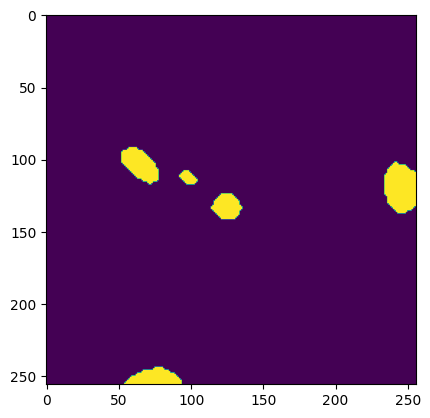

In [6]:
plt.imshow(train_ds[0][2].squeeze())

In [7]:
len(train_dl),len(val_dl)

(5500, 11948)

In [8]:
torch.cuda.empty_cache()

In [9]:
model = TransUNetLike()

In [10]:
train(model,4,1e-4,train_dl,val_dl,model_name="TransUNet_no_dice_loss",dataset_type="weih_to_i3",gt_only=True)

  0%|          | 0/4 [00:00<?, ?it/s]

Epoch 0, Batch 0, Loss: 0.7032, iou: 0.0044 
Epoch 0, Batch 100, Loss: 0.1290, iou: 0.0000 
Epoch 0, Batch 200, Loss: 0.1836, iou: 0.0000 
Epoch 0, Batch 300, Loss: 0.1532, iou: 0.0379 
Epoch 0, Batch 400, Loss: 0.0028, iou: 0.0000 
Epoch 0, Batch 500, Loss: 0.0563, iou: 0.0276 
Epoch 0, Batch 600, Loss: 0.1830, iou: 0.0000 
Epoch 0, Batch 700, Loss: 0.0918, iou: 0.0000 
Epoch 0, Batch 800, Loss: 0.1554, iou: 0.0000 
Epoch 0, Batch 900, Loss: 0.0975, iou: 0.3603 
Epoch 0, Batch 1000, Loss: 0.0799, iou: 0.0059 
Epoch 0, Batch 1100, Loss: 0.1210, iou: 0.0285 
Epoch 0, Batch 1200, Loss: 0.1452, iou: 0.0102 
Epoch 0, Batch 1300, Loss: 0.0268, iou: 1.0000 
Epoch 0, Batch 1400, Loss: 0.2078, iou: 0.1111 
Epoch 0, Batch 1500, Loss: 0.1062, iou: 0.0000 
Epoch 0, Batch 1600, Loss: 0.1558, iou: 0.0000 
Epoch 0, Batch 1700, Loss: 0.1078, iou: 0.0006 
Epoch 0, Batch 1800, Loss: 0.1077, iou: 0.0000 
Epoch 0, Batch 1900, Loss: 0.1575, iou: 0.0041 
Epoch 0, Batch 2000, Loss: 0.0323, iou: 1.0000 
Epoc

 25%|██▌       | 1/4 [09:25<28:15, 565.28s/it, train_loss=0.275, train_iou=0.0385, val_loss=0.219, val_iou=0.518]

Epoch 1, Batch 0, Loss: 0.0136, iou: 0.0000 
Epoch 1, Batch 100, Loss: 0.1880, iou: 0.0087 
Epoch 1, Batch 200, Loss: 0.0879, iou: 0.0000 
Epoch 1, Batch 300, Loss: 0.1021, iou: 0.1233 
Epoch 1, Batch 400, Loss: 0.0874, iou: 0.0018 
Epoch 1, Batch 500, Loss: 0.1295, iou: 0.0153 
Epoch 1, Batch 600, Loss: 0.2759, iou: 0.0014 
Epoch 1, Batch 700, Loss: 0.0950, iou: 0.0000 
Epoch 1, Batch 800, Loss: 0.0763, iou: 0.0078 
Epoch 1, Batch 900, Loss: 0.1218, iou: 0.0011 
Epoch 1, Batch 1000, Loss: 0.1602, iou: 0.0013 
Epoch 1, Batch 1100, Loss: 0.0496, iou: 0.0000 
Epoch 1, Batch 1200, Loss: 0.2889, iou: 0.0135 
Epoch 1, Batch 1300, Loss: 0.1925, iou: 0.0033 
Epoch 1, Batch 1400, Loss: 0.1501, iou: 0.0131 
Epoch 1, Batch 1500, Loss: 0.1778, iou: 0.0000 
Epoch 1, Batch 1600, Loss: 0.1783, iou: 0.0006 
Epoch 1, Batch 1700, Loss: 0.1485, iou: 0.0643 
Epoch 1, Batch 1800, Loss: 0.2241, iou: 0.0004 
Epoch 1, Batch 1900, Loss: 0.2652, iou: 0.0004 
Epoch 1, Batch 2000, Loss: 0.0443, iou: 0.0000 
Epoc

 50%|█████     | 2/4 [18:53<18:54, 567.10s/it, train_loss=0.294, train_iou=0.0334, val_loss=0.337, val_iou=0.418]

Epoch 2, Batch 0, Loss: 1.0070, iou: 0.0462 
Epoch 2, Batch 100, Loss: 0.7168, iou: 0.0522 
Epoch 2, Batch 200, Loss: 0.3572, iou: 0.0000 
Epoch 2, Batch 300, Loss: 1.9931, iou: 0.0341 
Epoch 2, Batch 400, Loss: 0.1914, iou: 0.0000 
Epoch 2, Batch 500, Loss: 0.0494, iou: 0.0000 
Epoch 2, Batch 600, Loss: 0.4561, iou: 0.0353 
Epoch 2, Batch 700, Loss: 0.1431, iou: 0.0185 
Epoch 2, Batch 800, Loss: 0.0870, iou: 0.0445 
Epoch 2, Batch 900, Loss: 0.5017, iou: 0.0159 
Epoch 2, Batch 1000, Loss: 5.4560, iou: 0.0069 
Epoch 2, Batch 1100, Loss: 1.0939, iou: 0.0114 
Epoch 2, Batch 1200, Loss: 1.6480, iou: 0.0619 
Epoch 2, Batch 1300, Loss: 0.2978, iou: 0.0457 
Epoch 2, Batch 1400, Loss: 0.9485, iou: 0.0273 
Epoch 2, Batch 1500, Loss: 24.6874, iou: 0.0496 
Epoch 2, Batch 1600, Loss: 1.6241, iou: 0.0000 
Epoch 2, Batch 1700, Loss: 615.1565, iou: 0.0000 
Epoch 2, Batch 1800, Loss: 55.7249, iou: 0.0427 
Epoch 2, Batch 1900, Loss: 18.9918, iou: 0.0403 
Epoch 2, Batch 2000, Loss: 1.3499, iou: 0.0000 

 75%|███████▌  | 3/4 [28:41<09:36, 576.79s/it, train_loss=71.9, train_iou=0.028, val_loss=207, val_iou=0.0693]   

Epoch 3, Batch 0, Loss: 82.3662, iou: 0.0442 
Epoch 3, Batch 100, Loss: 422.6803, iou: 0.0097 
Epoch 3, Batch 200, Loss: 7.0587, iou: 0.0029 
Epoch 3, Batch 300, Loss: 30.6059, iou: 0.0598 
Epoch 3, Batch 400, Loss: 72.7818, iou: 0.0563 
Epoch 3, Batch 500, Loss: 18.1563, iou: 0.0089 
Epoch 3, Batch 600, Loss: 21.7629, iou: 0.0311 
Epoch 3, Batch 700, Loss: 7.7822, iou: 0.0368 
Epoch 3, Batch 800, Loss: 10.5523, iou: 0.0268 
Epoch 3, Batch 900, Loss: 21.9496, iou: 0.0591 
Epoch 3, Batch 1000, Loss: 4.3332, iou: 0.0080 
Epoch 3, Batch 1100, Loss: 983.5655, iou: 0.0118 
Epoch 3, Batch 1200, Loss: 928.7393, iou: 0.0160 
Epoch 3, Batch 1300, Loss: 43.6040, iou: 0.0023 
Epoch 3, Batch 1400, Loss: 24.4166, iou: 0.0526 
Epoch 3, Batch 1500, Loss: 233.8241, iou: 0.1168 
Epoch 3, Batch 1600, Loss: 8.3471, iou: 0.0043 
Epoch 3, Batch 1700, Loss: 66.4007, iou: 0.0378 
Epoch 3, Batch 1800, Loss: 5.9518, iou: 0.0237 
Epoch 3, Batch 1900, Loss: 38.8937, iou: 0.0318 
Epoch 3, Batch 2000, Loss: 39.298

100%|██████████| 4/4 [38:01<00:00, 570.41s/it, train_loss=7.62e+3, train_iou=0.0233, val_loss=2.8e+4, val_iou=0.114]


In [ ]:

df = pd.read_csv('./unet_train_iou_log_final.csv')
df.mean()

iteration        841.496919
ema_vs_gt_iou      0.792255
sam_vs_gt_iou      0.105006
pl_vs_gt_iou       0.295416
ema_vs_pl_iou      0.338215
sam_vs_pl_iou      0.073812
dtype: float64

In [4]:
df = pd.read_csv('./unet_test_iou_log_final.csv')
df.mean()

iteration        1792.000000
ema_vs_gt_iou       0.469145
sam_vs_gt_iou       0.609988
pl_vs_gt_iou        0.470007
ema_vs_pl_iou       0.961024
sam_vs_pl_iou       0.442005
dtype: float64

In [25]:

df = pd.read_csv('./train_iou_log_final.csv')
df.mean()

iteration        7813.052156
ema_vs_gt_iou       0.922296
sam_vs_gt_iou       0.677349
pl_vs_gt_iou        0.914467
ema_vs_pl_iou       0.967686
sam_vs_pl_iou       0.685986
dtype: float64

In [26]:
df = pd.read_csv('./test_iou_log_final.csv')
df.mean()

iteration        21594.735928
ema_vs_gt_iou        0.326658
sam_vs_gt_iou        0.076785
pl_vs_gt_iou         0.326160
ema_vs_pl_iou        0.954620
sam_vs_pl_iou        0.134369
dtype: float64

In [3]:
chckp = torch.load("refinement_results/EncodeDecode_mix_with_dice_loss_train_on_weih_to_i3_on_gt/best_checkpoint.pth")


In [10]:
model.load_state_dict(chckp["model_state_dict"])

<All keys matched successfully>

In [11]:
model = model.cuda()

In [18]:
def plot_pred(index):
    pl_image, sam_image, gt_image = [x.cuda() for x in val_ds[index]]
    #result_mask1, result_mask2 = batch_extract_mix_redistribute(pl_image, sam_image,False)
    gt_preds = model(pl_image.to(torch.float).unsqueeze(1),sam_image.to(torch.float).unsqueeze(1)) 
    fig,axes = plt.subplots(2,3,figsize=(16,8))
    axes = axes.flatten()
    axes[0].imshow(pl_image.squeeze().cpu().detach())
    axes[0].set_title("ema")
    axes[0].axis("off")
    axes[1].imshow(sam_image.squeeze().cpu().detach())
    axes[1].set_title("sam")
    axes[1].axis("off")
    axes[2].imshow(gt_image.squeeze().cpu().detach())
    axes[2].set_title("gt")
    axes[2].axis("off")
    axes[3].imshow(pl_image.squeeze().cpu().detach())
    axes[3].set_title("pl_image")
    axes[3].axis("off")
    axes[4].imshow(sam_image.squeeze().cpu().detach())
    axes[4].set_title("sam_image")
    axes[4].axis("off")
    axes[5].imshow(gt_preds.argmax(dim=1).squeeze().cpu().detach())
    axes[5].set_title("gt_preds")
    axes[5].axis("off")


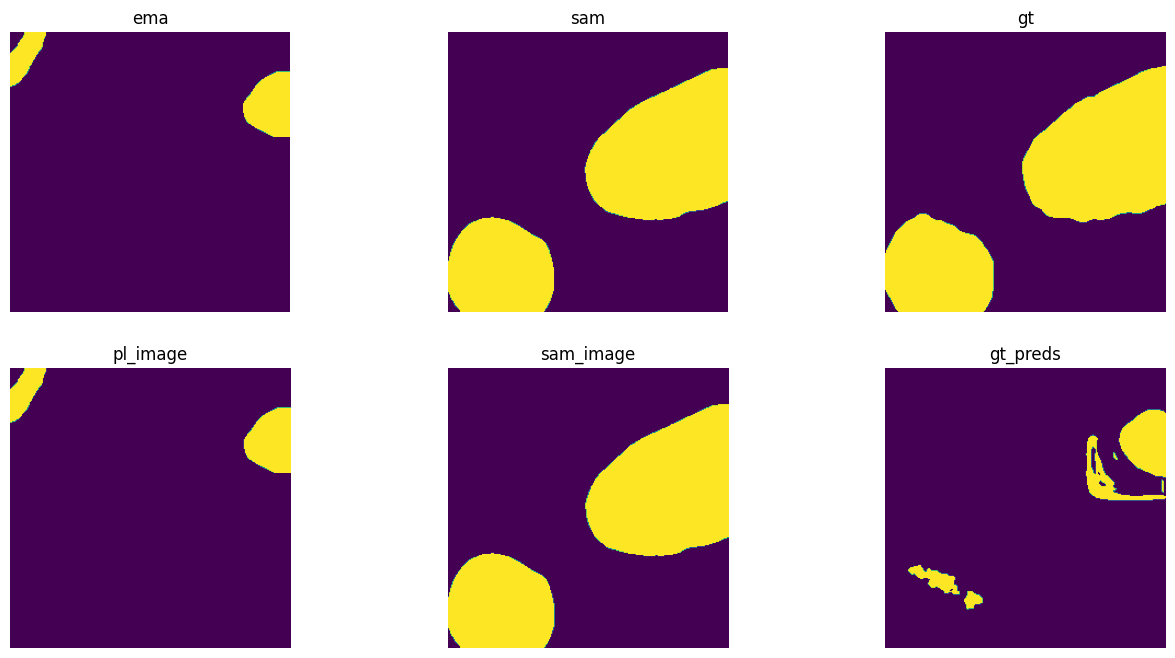

In [30]:
plot_pred(3000)